In [1]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from deep_utils.utils.multi_label_utils.stratify.stratify_train_test_split import stratify_train_test_split_multi_label

import sys
sys.path.append("../")
from src.dataset_to_bio import dataset_to_text_with_labels, texts_labels_to_bio, labels_to_id
from src.augmentations import *

In [2]:
SEED = 2024*5
random.seed(SEED)
np.random.seed(SEED)

In [3]:
with open("../data/share/train.json", encoding="utf-8") as f:
    data = json.load(f)

Исправление неточностей в разметке:

In [ ]:
# for sample in data:
#     text = sample["text"]
#     entities = sample["entities"]
#     for i, entity in enumerate(entities):
#         word = entity["word"]
#         start = entity["start"]
#         end = entity["end"]

#         actual_word = text[start:end]
#         if actual_word != word:
            
            
#             if entity["entity_group"] == "ACRONYM":
#                 entity["start"] += 1
#                 entity["end"] -= 1
#             elif entity["entity_group"] == "TELEPHONE":
#                 if i + 1 < len(entities):
#                     next_start = entities[i + 1]["start"]
#                     entity["end"] = next_start

# Переведем тексты в формат фрагмент - метка

In [4]:
dataset_texts, dataset_labels = dataset_to_text_with_labels(data)
sample_id = 174
sample = dataset_texts[sample_id]
print(len(sample), sample)
print(len(dataset_labels[sample_id]), dataset_labels[sample_id])

11 ['В инструкции содержится информация о наименованиях,', ' HMN ', 'расходных материалов и моющих средств, способ и частота формирования заказа и т.д.  \n\n\nПеречень изменений на 2', '28.36%', '8.23:\n\n* скорректировано количество по первой поставке средств для чистки молочной системы ', 'KvantumKore', ' и ', 'BGI', ';\n* произведён перерасчёт среднего расхода в месяц по средству для чистки молочной системы ', 'BGI', '.']
11 ['O', 'ACRONYM', 'O', 'PERCENT', 'O', 'TECH', 'O', 'TECH', 'O', 'TECH', 'O']


In [5]:
data[sample_id]

{'text': 'В инструкции содержится информация о наименованиях, HMN расходных материалов и моющих средств, способ и частота формирования заказа и т.д.  \n\n\nПеречень изменений на 228.36%8.23:\n\n* скорректировано количество по первой поставке средств для чистки молочной системы KvantumKore и BGI;\n* произведён перерасчёт среднего расхода в месяц по средству для чистки молочной системы BGI.',
 'entities': [{'entity_group': 'ACRONYM',
   'word': 'HMN',
   'start': 51,
   'end': 56},
  {'entity_group': 'PERCENT', 'word': '28.36%', 'start': 166, 'end': 172},
  {'entity_group': 'TECH', 'word': 'KvantumKore', 'start': 263, 'end': 274},
  {'entity_group': 'TECH', 'word': 'BGI', 'start': 277, 'end': 280},
  {'entity_group': 'TECH', 'word': 'BGI', 'start': 371, 'end': 374}]}

In [6]:
for i, sample in enumerate(dataset_texts[:10]):
    print(sample)
    print(dataset_labels[i])

['**Когда квитанция поступит,** вАрхиве поступлений в «Статусе маркировки» отобразится статус по накладной «Продажа разрешена» или «Принято с расхождениями».  \n  \nПринятые марки добавятся на остатки магазина, **товары станут доступны для продажи на кассе**.\n* **Принято с расхождениями** – марки приняты НЕ ПО ВСЕМ товарам.  \n  \nНеобходимо провалиться в документ поступления и проверить статус маркировки по каждой ', '+7 010 618 1753', '.']
['O', 'TELEPHONE', 'O']
['**Контакты ответственных менеджеров по', ' MVU ', 'и', ' KIT ', 'каждой территории:**\n\n\n\n|  |  |  |\n| --- | --- | --- |\n| **Территория** | **ФИО менеджера** | **Эл. почта** |\n| Волга | ', 'Елисеева Олимпиада Максимовна', ' | ', 'ribakovapolina@zao.info', ' |\n| Восток | ', 'Колесников Селиверст Харламович', ' | ', 'erofesafonov@boes.info', ' |\n| Северо-Запад | ', 'Григорьев Зиновий Александрович', ' | ', 'fdoronin@tsvetkova.com', ' |\n| Центр | ', 'Агафон Егорович Селиверстов', ' | ', 'klavdi_2003@nesterova.ru', '

# Стратифицированное разбиение на train и test для задачи Name entity recognition при помощи библиотеки deep utils:

In [7]:
label2ids = {"O" : 0, "NAME" : 1, "NAME_EMPLOYEE" : 2,  "PERCENT" : 3,  
            "MAIL" : 4 , "LINK" : 5,  "NUM" : 6,  "DATE" : 7, "TELEPHONE" : 8,
            "ACRONYM" : 9, "ORG" : 10 , "TECH" : 11 }

ids2label = {v : k for k, v in label2ids.items()}

In [8]:
dataset_labels_ids = labels_to_id(dataset_labels, label2ids)

In [9]:
pad_width = 0
for arr in dataset_labels_ids:
    if len(arr) > pad_width:
        pad_width = len(arr)

for sample_ids in dataset_labels_ids:
    while len(sample_ids) <= pad_width:
        sample_ids.append(0)

In [10]:
x_train_, x_test_, y_train, y_test = stratify_train_test_split_multi_label([idx for idx in range(len(dataset_texts))], np.array(dataset_labels_ids), test_size=0.15)

In [11]:
x_train = [dataset_texts[idx] for idx in x_train_]
y_train = [dataset_labels[idx] for idx in x_train_]
y_train_ids = [dataset_labels_ids[idx] for idx in x_train_]
x_test = [dataset_texts[idx] for idx in x_test_]
y_test = [dataset_labels[idx] for idx in x_test_]
y_test_ids = [dataset_labels_ids[idx] for idx in x_test_]

In [12]:
print(len(x_train), len(x_test))

270 60


In [13]:
def count_labels(targets, ids2label, is_sorted=True):
    counts = {}
    for sample_ids in targets:
        for id in sample_ids:
            if id != 0:
                label = ids2label[id]
                if label not in counts.keys():
                    counts[label] = 0
                counts[label] +=1 
    if is_sorted:
        counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1])}
    return counts

In [14]:
counts_train = count_labels(y_train_ids, ids2label)
counts_test = count_labels(y_test_ids, ids2label)

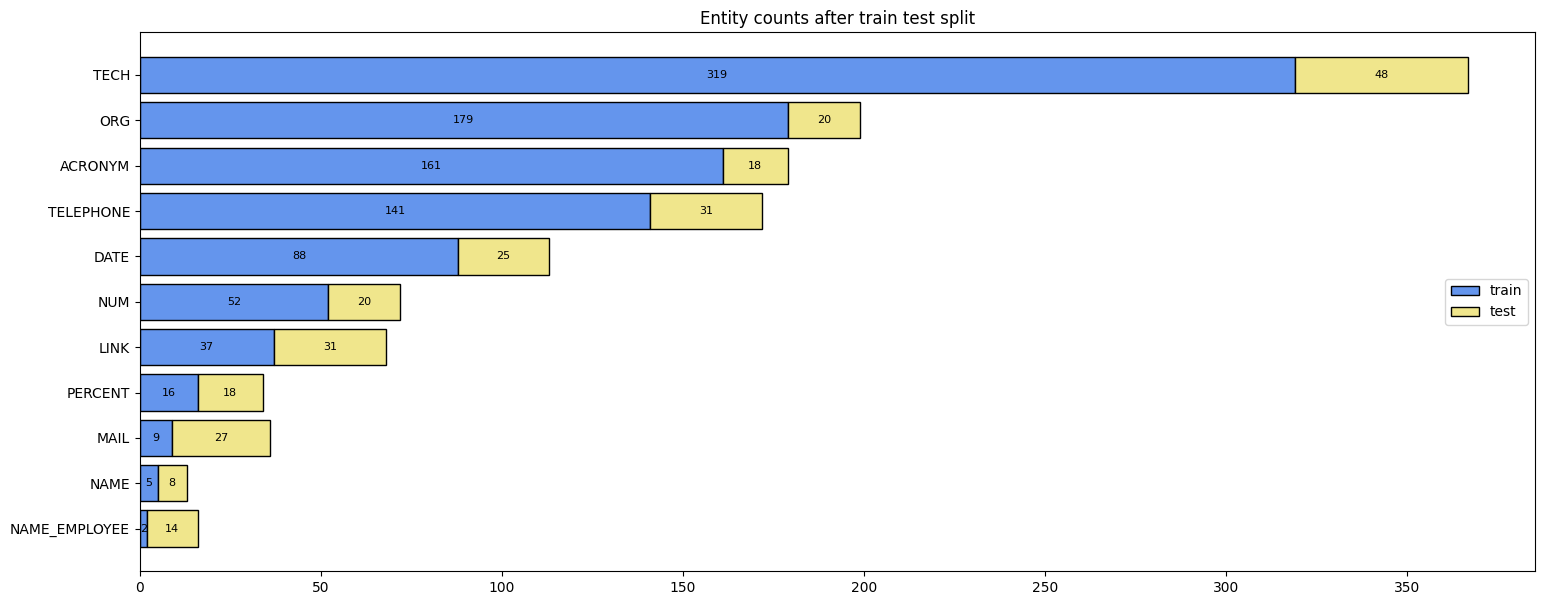

In [15]:
fig, ax = plt.subplots(figsize=(18, 7))
keys = counts_train.keys()
train_values = counts_train.values()
test_values = [counts_test[key] for key in keys]

bars = ax.barh(keys, train_values,  color="cornflowerblue", ec='black', label="train")
bars2 = ax.barh(keys, test_values,left=train_values, color="khaki", ec='black', label="test")
ax.bar_label(bars, label_type="center", fontsize=8)
ax.bar_label(bars2, label_type="center", fontsize=8)
ax.set_title("Entity counts after train test split")
ax.legend(loc="right")
plt.show()

# Создадим аугментрованный датасет:

In [16]:
aug_data, aug_labels = make_augmentations(x_train, y_train)
for i, sample in enumerate(aug_data[:10]):
    print(sample)
    print(aug_labels[i])

['31 Августа 2085 года', '8 393 186 0902', '20.01.1994']
['DATE', 'TELEPHONE', 'DATE']
['**', '+7 494 129 73 03', '** сотрудников — это внутрикорпоративная \nпрограмма для управления организацией, которая обеспечивает возможность \nкоммуникации, обмена документами, публикации достижений сотрудников и \nновостей компании. \n\n', '8 078 923 56 70', '67398']
['O', 'TELEPHONE', 'O', 'TELEPHONE', 'NUM']
['**Кто войдет в состав «', '8 354 542 9083', '1329', '+7 010 618 1753', '» сможет гость, соответствующий следующим критериям:\n\n* владельцем «', 'vasilisa_28@mail.ru', '»;\n* является пользователем мобильного приложения «', 'НПО РКЦ Прогресс', '2 Декабря', 'ЗАО Ренейссанс Констракшн (Ronesans Holding Anonim Sirketi)', '» минимум 1 раз в месяц;\n* совершал минимум 5 в магазинах «', 'РусВинил', '» за прошедший месяц.\n\nВступить в клуб без приглашения невозможно.\n\nСотрудники магазина могут быть участниками клуба.']
['O', 'TELEPHONE', 'NUM', 'TELEPHONE', 'O', 'MAIL', 'O', 'ORG', 'DATE', 'OR

# Создадим словари для перевода BIO-сущностей в их ID и наоборот

In [17]:
with open("../data_processed/entity_names.txt", encoding="utf-8") as f:
    entity_names = f.readlines()[0].split(" ")

labels2id = {"O" : 0}

bio_labels = []
for entity_name in sorted(entity_names):
    bio_labels.append("B-" + entity_name)
    bio_labels.append("I-" + entity_name)

for i, label in enumerate(bio_labels):
    labels2id[label] = i + 1

id2labels = {v : k for k, v in labels2id.items()}

with open("../data_processed/labels2id.json", "w", encoding="utf8") as f:
    json.dump(labels2id, f, ensure_ascii=False)

with open("../data_processed/id2labels.json", "w", encoding="utf8") as f:
    json.dump(id2labels, f, ensure_ascii=False)

print(labels2id)
print(id2labels)

{'O': 0, 'B-ACRONYM': 1, 'I-ACRONYM': 2, 'B-DATE': 3, 'I-DATE': 4, 'B-LINK': 5, 'I-LINK': 6, 'B-MAIL': 7, 'I-MAIL': 8, 'B-NAME': 9, 'I-NAME': 10, 'B-NAME_EMPLOYEE': 11, 'I-NAME_EMPLOYEE': 12, 'B-NUM': 13, 'I-NUM': 14, 'B-ORG': 15, 'I-ORG': 16, 'B-PERCENT': 17, 'I-PERCENT': 18, 'B-TECH': 19, 'I-TECH': 20, 'B-TELEPHONE': 21, 'I-TELEPHONE': 22}
{0: 'O', 1: 'B-ACRONYM', 2: 'I-ACRONYM', 3: 'B-DATE', 4: 'I-DATE', 5: 'B-LINK', 6: 'I-LINK', 7: 'B-MAIL', 8: 'I-MAIL', 9: 'B-NAME', 10: 'I-NAME', 11: 'B-NAME_EMPLOYEE', 12: 'I-NAME_EMPLOYEE', 13: 'B-NUM', 14: 'I-NUM', 15: 'B-ORG', 16: 'I-ORG', 17: 'B-PERCENT', 18: 'I-PERCENT', 19: 'B-TECH', 20: 'I-TECH', 21: 'B-TELEPHONE', 22: 'I-TELEPHONE'}


# Переведем фрагмент-метка формат в BIO формат: разделим каждый пример по пробелам и поставим в соответсвие BIO-метку

In [18]:
train_data_processed, train_labels = texts_labels_to_bio(x_train, y_train)
train_labels_ids = labels_to_id(train_labels, labels2id)

test_data_processed, test_labels = texts_labels_to_bio(x_test, y_test)
test_labels_ids = labels_to_id(test_labels, labels2id)

aug_data_processed, aug_labels = texts_labels_to_bio(aug_data, aug_labels)
aug_labels_ids = labels_to_id(aug_labels, labels2id)

In [19]:
print(len(train_data_processed[sample_id]), train_data_processed[sample_id])
print(len(train_labels[sample_id]), train_labels[sample_id])
print(train_labels_ids[sample_id])

66 ['Если', 'в', 'магазин', 'без', 'сервиса', '+7', '010', '618', '1753', 'приходит', 'сырье,', 'то', 'необходимо', 'сообщить', 'QHJ', 'для', 'дальнейшего', 'обращения', 'к', 'PNQ', 'территории.', '\n\n**По', 'территории', 'Центр**', 'алгоритм', 'обращения', 'следующий:\n\n\n\n|', '|', '|', '|\n|', '---', '|', '---', '|', '---', '|\n|', 'Причина', 'обращения', '|', 'Канал', 'коммуникации:', '|', 'Описание', 'действий,', 'сроки:', '|\n|', '**Заявки', 'по', 'Хлебопечи', 'и', 'опциям', 'Кофе/Сок**:', '*', 'закупка', 'и', 'установка', 'новой', 'Печи\n*', 'перенос/демонтаж/поломка', 'Печи\n*', 'установка/демонтаж/поломка', 'Кофемашины,', 'Сокомашины\n*', 'снижение', 'TFS', 'Пекарни']
66 ['O', 'O', 'O', 'O', 'O', 'B-TELEPHONE', 'I-TELEPHONE', 'I-TELEPHONE', 'I-TELEPHONE', 'O', 'O', 'O', 'O', 'O', 'B-ACRONYM', 'O', 'O', 'O', 'O', 'B-ACRONYM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [20]:
print(len(aug_data_processed[sample_id]), aug_data_processed[sample_id])
print(len(aug_labels[sample_id]), aug_labels[sample_id])
print(aug_labels_ids[sample_id])

22 ['Если', 'в', 'магазин', 'без', '8', '(306)', '320-56-42', 'приходит', 'сырье,', 'то', 'сообщить', '66%', 'для', 'дальнейшего', 'к', 'HBJA', '8', '510', '012', '8505', 'ШВХЫВ', 'Пекарни']
22 ['O', 'O', 'O', 'O', 'B-TELEPHONE', 'I-TELEPHONE', 'I-TELEPHONE', 'O', 'O', 'O', 'O', 'B-PERCENT', 'O', 'O', 'O', 'B-ACRONYM', 'B-TELEPHONE', 'I-TELEPHONE', 'I-TELEPHONE', 'I-TELEPHONE', 'B-ACRONYM', 'O']
[0, 0, 0, 0, 21, 22, 22, 0, 0, 0, 0, 17, 0, 0, 0, 1, 21, 22, 22, 22, 1, 0]


# Подготовим данные для более удобного чтения через библиотеку datasets от hugginface:

In [21]:
from datasets import Dataset

d:\Projects\Codenrock\maskirovanie-5629\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def create_list_dataset(data, labels_ids, labels_names):
    list_dataset = []
    for i in range(len(data)):
        tokens = data[i]
        tags = labels_ids[i]
        names = labels_names[i]
        list_dataset.append({"id" : i, "tokens" : tokens, "ner_tags" : tags, "ner_names" : names }) 

    return list_dataset

In [23]:
train_list_dataset = create_list_dataset(train_data_processed, train_labels_ids, train_labels)
test_list_dataset = create_list_dataset(test_data_processed, test_labels_ids, test_labels)

aug_list_dataset = create_list_dataset(aug_data_processed, aug_labels_ids, aug_labels)

In [24]:
train_dataset = Dataset.from_list(train_list_dataset)
test_dataset = Dataset.from_list(test_list_dataset)

aug_dataset = Dataset.from_list(aug_list_dataset)

In [ ]:
aug_dataset.save_to_disk("../data_processed/aug_dataset")
train_dataset.save_to_disk("../data_processed/train_dataset")
test_dataset.save_to_disk("../data_processed/test_dataset")